# Проект телекоммуникации
Оператор связи "ТелеДом" стремится снизить отток клиентов, предлагая им специальные условия, если они планируют отказаться от услуг. Для этого необходима модель МО, которая способна предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные клиентов, а также информацию о их тарифах и услугах с целью разработки такой модели.

***Цель исследования:*** заключается в обучении модели машинного обучения, способной предсказывать отток клиентов оператора связи "ТелеДом".

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from skimpy import clean_columns
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.model_selection import (
    train_test_split, GridSearchCV)
from sklearn.preprocessing import (
    OneHotEncoder, StandardScaler, MinMaxScaler)
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import shap 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## 1. Загрузка данных
#### 1.1 Загрузка данных и изучение общей информации

In [2]:
try:
    contract_df = pd.read_csv("/datasets/contract_new.csv", parse_dates=['BeginDate'])
    person_df = pd.read_csv("/datasets/personal_new.csv")
    internet_df = pd.read_csv("/datasets/internet_new.csv")
    phone_df = pd.read_csv("/datasets/phone_new.csv")
except FileNotFoundError:
    contract_df = pd.read_csv(r"C:\Users\Тадевос\Tadevos\USER\Desktop\Курсы\Модуль 4\Датасеты к проектам\Диплом\contract_new.csv", parse_dates=['BeginDate'])
    person_df = pd.read_csv(r"C:\Users\Тадевос\Tadevos\USER\Desktop\Курсы\Модуль 4\Датасеты к проектам\Диплом\personal_new.csv")
    internet_df = pd.read_csv(r"C:\Users\Тадевос\Tadevos\USER\Desktop\Курсы\Модуль 4\Датасеты к проектам\Диплом\internet_new.csv")
    phone_df = pd.read_csv(r"C:\Users\Тадевос\Tadevos\USER\Desktop\Курсы\Модуль 4\Датасеты к проектам\Диплом\phone_new.csv")

In [3]:
contract_df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [4]:
contract_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 440.3+ KB


In [5]:
person_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [6]:
person_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [7]:
internet_df.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [8]:
internet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [9]:
phone_df.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [10]:
phone_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


> **Выводы по первому шагу:**
>
> В первом шаге были проделаны следующие действия: 
>  - загрузка данных;
>  - изучение общей информации о данных.
>
> **После загрузки и изучения данных можно сделать несколько выводов:**
> 1. названия столбцов не соответствуют стандартам pep8;
> 2. во всех датафреймах нет пропущенных значений;
> 3. в датафрейме **'contract_df'** тип данных не соответствует значениям.

##  2. Исследовательский анализ и предобработка данных
#### 2.1 Переименование столбцов в датафреймах

In [11]:
# Приведение названий столбцов к snake_case
contract_df = clean_columns(contract_df)
person_df = clean_columns(person_df)
internet_df = clean_columns(internet_df)
phone_df = clean_columns(phone_df)

In [12]:
internet_df

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No


In [13]:
contract_df

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,2035.2
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7430.4
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,325.6
7041,8361-LTMKD,2019-07-01,No,Month-to-month,Yes,Mailed check,74.40,520.8


#### 2.2 Изменение типа данных

In [14]:
# Преобразование столбца "TotalCharges" в числовой формат
contract_df['total_charges'] = pd.to_numeric(contract_df['total_charges'], errors='coerce')
# Проверка количества непустых значений до и после преобразования
print("Количество непустых значений до преобразования:", contract_df['total_charges'].notnull().sum())
contract_df['total_charges'] = contract_df['total_charges'].fillna(0)  # Замена NaN значений на 0
print("Количество непустых значений после преобразования:", contract_df['total_charges'].notnull().sum())

Количество непустых значений до преобразования: 7032
Количество непустых значений после преобразования: 7043


In [15]:
# Заменяем значения в столбце 'SeniorCitizen'
person_df['senior_citizen'] = person_df['senior_citizen'].replace({0: 'No', 1: 'Yes'})

# Просмотр обновленного датафрейма
person_df.head()

,customer_id,gender,senior_citizen,partner,dependents
0,7590-VHVEG,Female,No,Yes,No
1,5575-GNVDE,Male,No,No,No
2,3668-QPYBK,Male,No,No,No
3,7795-CFOCW,Male,No,No,No
4,9237-HQITU,Female,No,No,No


#### 2.3 Поиск и устранение дубликатов
##### 2.3.1 Поиск явных дубликатов

In [16]:
# Выводим на экран количество строк-дубликатов в каждом из датафреймов
contract_duplicates = contract_df.duplicated().sum()
person_duplicates = person_df.duplicated().sum()
internet_duplicates = internet_df.duplicated().sum()
phone_duplicates = phone_df.duplicated().sum()

print(contract_duplicates, person_duplicates, 
      internet_duplicates, phone_duplicates)

0 0 0 0


##### 2.3.2 Поиск неявных дубликатов и построение графиков

In [17]:
# Функция 1 - для категориальных столбцов
def plot_categorical_countplot(data, column, title, xlabel, ylabel,
                                order=None, edgecolor='black'):
    plt.figure(figsize=(14, 6))

    # Если порядок не задан, сортируем значения столбца по убыванию
    if order is None:
        order = data[column].value_counts().index.tolist()

    sns.countplot(data=data, x=column, order=order, edgecolor=edgecolor)

    # Добавляем аннотации с количеством над каждым столбцом
    for p in plt.gca().patches:
        plt.gca().annotate(f'{int(p.get_height())}', 
                           (p.get_x() + p.get_width() / 2., p.get_height()),
                           ha='center', va='center', fontsize=12, color='black', 
                           xytext=(0, 5), textcoords='offset points')

    plt.title(title)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.show()

# Функция 2 - для столбцов логического типа
def plot_internet_service_options(pivot_table_internet, columns_of_interest):
    # Значения из сводной таблицы
    yes_values = pivot_table_internet.loc['Yes', columns_of_interest].values
    no_values = pivot_table_internet.loc['No', columns_of_interest].values

    # Категории услуг
    categories = columns_of_interest

    # Сортировка по убыванию для значений "No"
    sorted_indices = np.argsort(no_values)[::-1]  # Индексы в порядке убывания
    no_values = no_values[sorted_indices]
    categories = np.array(categories)[sorted_indices]  # Применяем ту же сортировку к категориям

    # Параметры для графика
    bar_width = 0.35
    index = np.arange(len(categories))

    # Создание фигуры графика с указанным размером
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Создание графика
    bars1 = ax.bar(index, yes_values, bar_width, label='Yes', edgecolor='black')
    bars2 = ax.bar(index + bar_width, no_values, bar_width, label='No', edgecolor='black')

    # Добавление названий категорий и легенды
    ax.set_xlabel('Категории', fontsize=14)
    ax.set_ylabel('Частота', fontsize=14)
    ax.set_title('График бинарной классификации', fontsize=14)
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(categories, fontsize=14)
    ax.legend()

     # Добавление меток на столбцах
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{int(height)}', 
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=12)

    # Отображение графика
    plt.xticks()
    plt.tight_layout()
    plt.show()

In [18]:
# Выбираем столбцы с категориальными значениями
selected_columns_contract = ['type', 'paperless_billing', 'payment_method']

# Создаем сводную таблицу с value_counts
pivot_table_contract = pd.concat([contract_df[col].value_counts().rename(col) 
                                  for col in selected_columns_contract], axis=1)

# Заменяем NaN на "-"
pivot_table_contract = pivot_table_contract.fillna("-")

# Выводим сводную таблицу
pivot_table_contract

,type,paperless_billing,payment_method
Month-to-month,3875.0,-,-
Two year,1695.0,-,-
One year,1473.0,-,-
Yes,-,4171.0,-
No,-,2872.0,-
Electronic check,-,-,2365.0
Mailed check,-,-,1612.0
Bank transfer (automatic),-,-,1544.0
Credit card (automatic),-,-,1522.0


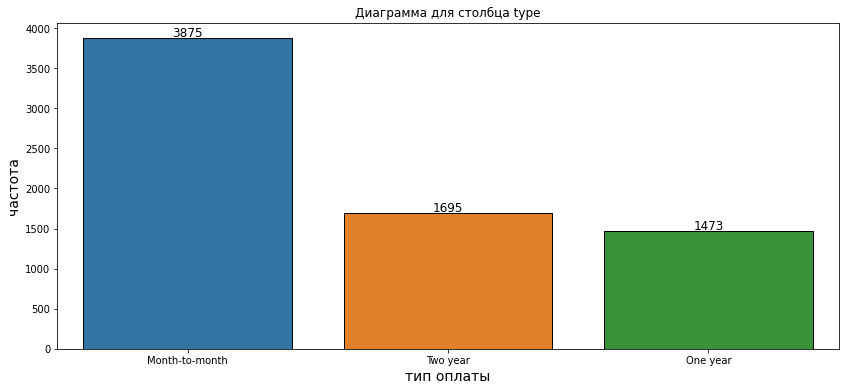

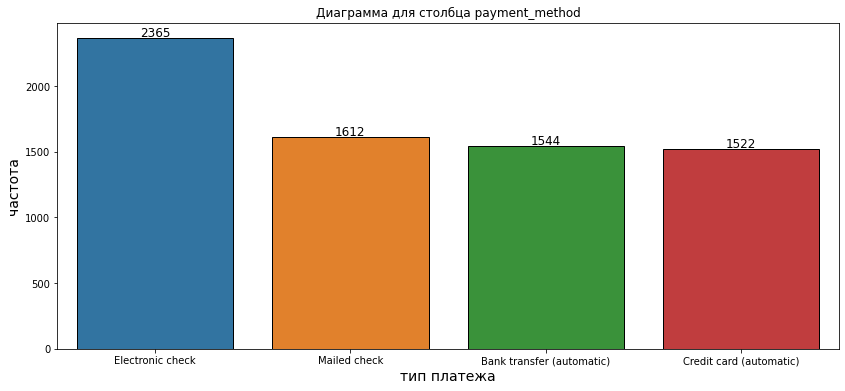

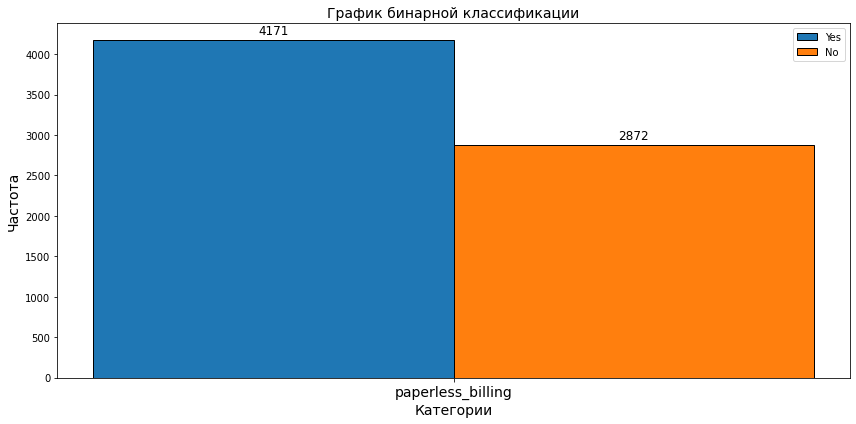

In [19]:
# Функция 1
plot_categorical_countplot(contract_df, 'type', 
                           'Диаграмма для столбца type', 'тип оплаты', 'частота')
plot_categorical_countplot(contract_df, 'payment_method', 
                           'Диаграмма для столбца payment_method', 'тип платежа', 'частота')
# Функция 2
columns_of_contract = ['paperless_billing']
plot_internet_service_options(pivot_table_contract, columns_of_contract)

In [20]:
# Выбираем столбцы с категориальными значениями
selected_columns_person = ['gender', 'senior_citizen', 'partner', 'dependents']

# Создаем сводную таблицу с value_counts
pivot_table_person = pd.concat([person_df[col].value_counts().rename(col) 
                                for col in selected_columns_person], axis=1)

# Заменяем NaN на "-"
pivot_table_person = pivot_table_person.fillna("-")

# Выводим сводную таблицу
pivot_table_person

,gender,senior_citizen,partner,dependents
Male,3555.0,-,-,-
Female,3488.0,-,-,-
No,-,5901.0,3641.0,4933.0
Yes,-,1142.0,3402.0,2110.0


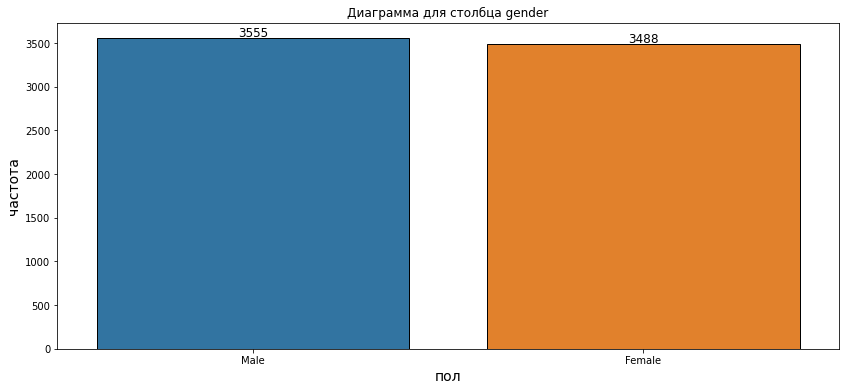

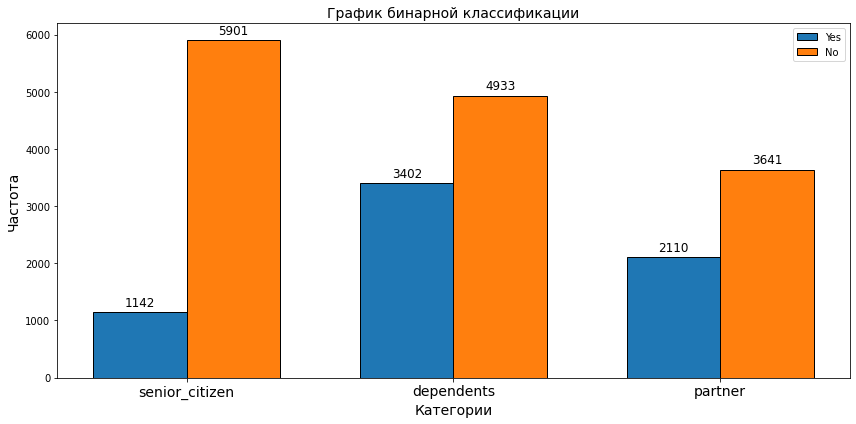

In [21]:
# Функция 1
plot_categorical_countplot(person_df, 'gender', 
                           'Диаграмма для столбца gender', 'пол', 'частота')
# Функция 2
columns_of_interest = ['senior_citizen', 'partner', 'dependents']
plot_internet_service_options(pivot_table_person, columns_of_interest)

In [22]:
# Выбираем столбцы с категориальными значениями
selected_columns_internet = ['internet_service', 'online_security',
                            'online_backup', 'device_protection',
                            'tech_support', 'streaming_tv',
                            'streaming_movies']

# Создаем сводную таблицу с value_counts
pivot_table_internet = pd.concat([internet_df[col].value_counts().rename(col) 
                                  for col in selected_columns_internet], axis=1)

# Заменяем NaN на "-"
pivot_table_internet = pivot_table_internet.fillna("-")

# Выводим сводную таблицу
pivot_table_internet

,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
Fiber optic,3096.0,-,-,-,-,-,-
DSL,2421.0,-,-,-,-,-,-
No,-,3498.0,3088.0,3095.0,3473.0,2810.0,2785.0
Yes,-,2019.0,2429.0,2422.0,2044.0,2707.0,2732.0


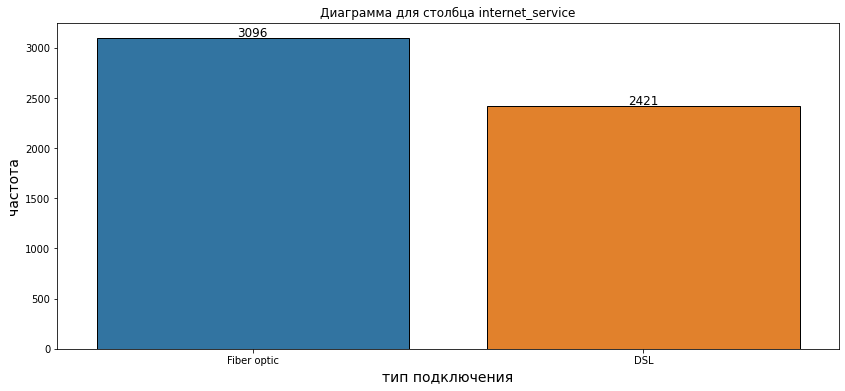

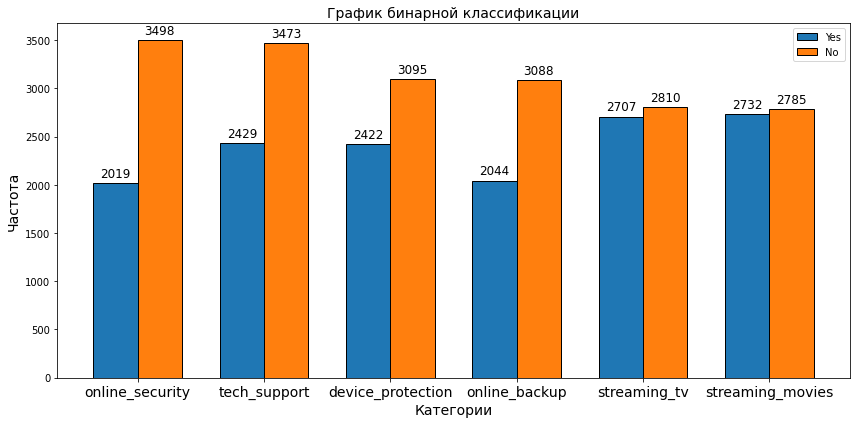

In [23]:
# Функция 1
plot_categorical_countplot(internet_df, 'internet_service', 
                           'Диаграмма для столбца internet_service', 'тип подключения', 'частота')
# Функция 2
columns_of_interest = ['online_security', 'online_backup', 'device_protection',
                        'tech_support', 'streaming_tv', 'streaming_movies']
plot_internet_service_options(pivot_table_internet, columns_of_interest)

In [24]:
# Выбираем столбцы с категориальными значениями
selected_columns_phone = ['multiple_lines']

# Создаем сводную таблицу с value_counts
pivot_table_phone = pd.concat([phone_df[col].value_counts().rename(col) 
                               for col in selected_columns_phone], axis=1)

# Заменяем NaN на "-"
pivot_table_phone = pivot_table_phone.fillna("-")

# Выводим сводную таблицу
pivot_table_phone

,multiple_lines
multiple_lines,
No,3390
Yes,2971


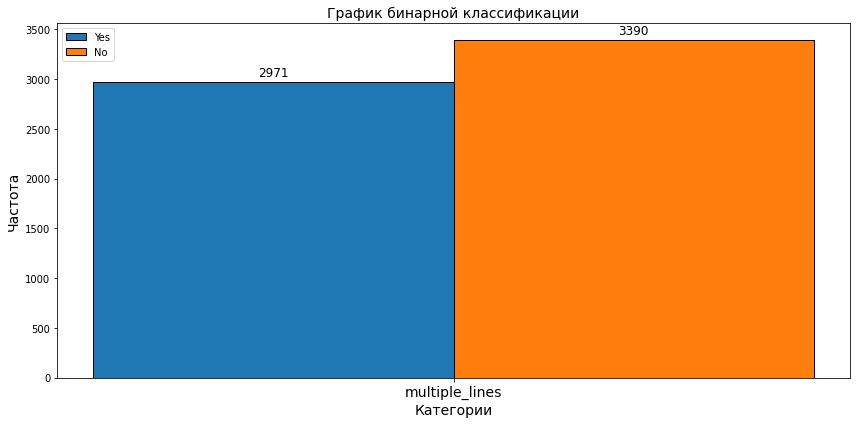

In [25]:
# Функция 2
columns_of_phone = ['multiple_lines']
plot_internet_service_options(pivot_table_phone, columns_of_phone)

#### 2.4 Поиск аномальных значений

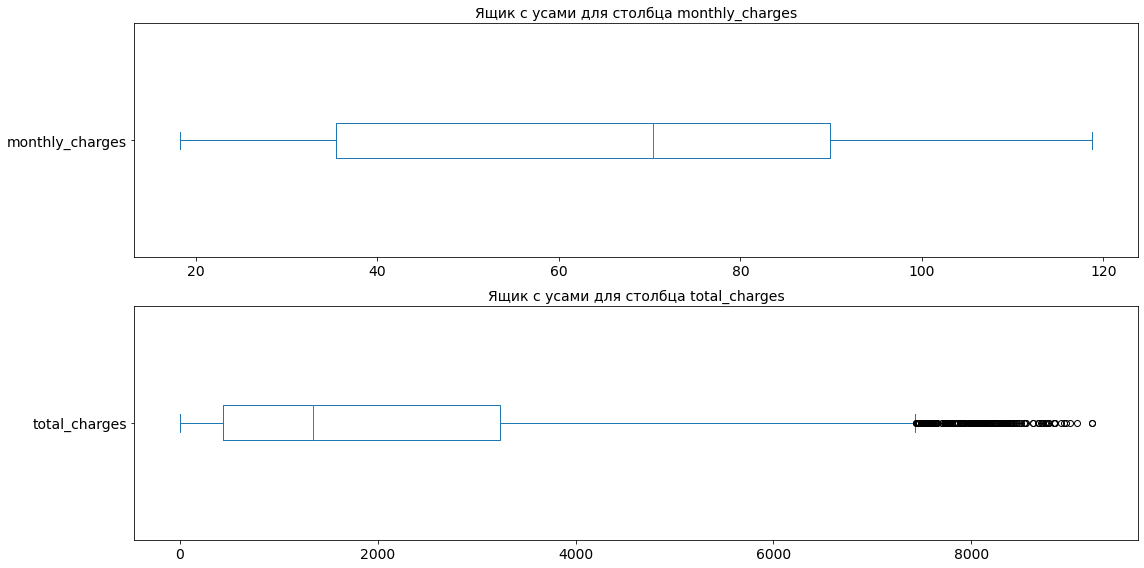

In [26]:
# Создаём переменную в который будет список с количественными значениями
cols_to_check = ['monthly_charges', 'total_charges']

fig, axes = plt.subplots(nrows=len(cols_to_check), figsize=(16, 8))

for i, col in enumerate(cols_to_check):
    contract_df[col].plot(kind='box', vert=False, ax=axes[i], fontsize=14)
    axes[i].set_title(f"Ящик с усами для столбца {col}", fontsize=14)

plt.tight_layout()
plt.show()

> **Выводы по второму шагу:**
>
> Во втором шаге были проделаны следующие действия: 
>  - переименованы столбцы;
>  - изменён тип данных, где это необходимо;
>  - поиск явных и неявных дубликатов;
>  - созданы функции для построения графиков;
>  - построены графики по всем признакам;
>  -  дубликаты и аномалии не обнаружены.

## 3 Объединение таблиц

In [27]:
# Объединяем все датафреймы с использованием полного объединения
merged_df = contract_df.merge(
    person_df, on='customer_id', how='left').merge(
        phone_df, on='customer_id', how='left').merge(
            internet_df, on='customer_id', how='left')

In [28]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   object        
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  multiple_lines     6361 non-null   object        
 13  internet_service   5517 non-null   object        
 14  online_s

In [29]:
columns_to_fill = ['internet_service', 'online_security', 'online_backup', 
                   'device_protection', 'tech_support', 'streaming_tv', 
                   'streaming_movies', 'multiple_lines']

for column in columns_to_fill:
    merged_df[column].fillna('other', inplace=True)

In [30]:
merged_df['end_date'] = merged_df['end_date'].replace('No', '2020-02-01')
merged_df[['begin_date', 'end_date']] = merged_df[['begin_date', 'end_date']].apply(pd.to_datetime)
merged_df['duration_days']= (merged_df['end_date']-merged_df['begin_date']).dt.days

# Создаем целевой признак
merged_df['target'] = np.where(merged_df['end_date'] == '2020-02-01', 1, 0)

# Выводим результат
merged_df[['end_date', 'begin_date', 'duration_days', 'target']].head(-5)

,end_date,begin_date,duration_days,target
0,2020-02-01,2020-01-01,31,1
1,2020-02-01,2017-04-01,1036,1
2,2020-02-01,2019-10-01,123,1
3,2020-02-01,2016-05-01,1371,1
4,2020-02-01,2019-09-01,153,1
...,...,...,...,...
7033,2020-02-01,2016-12-01,1157,1
7034,2015-11-01,2014-03-01,610,0
7035,2020-02-01,2018-07-01,580,1
7036,2020-02-01,2019-02-01,365,1


In [31]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   object        
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  multiple_lines     7043 non-null   object        
 13  internet_service   7043 non-null   object        
 14  online_s

In [32]:
merged_df['target'].value_counts()

target
1    5942
0    1101
Name: count, dtype: int64

In [33]:
# Удаление лишних признаков 
merged_df = merged_df.drop(columns=['begin_date', 'end_date'])

# Проверка на наличие дубликатов
duplicates = merged_df.duplicated()

# Подсчет количества дубликатов
num_duplicates = duplicates.sum()

if num_duplicates > 0:
    print(f"Обнаружено {num_duplicates} дубликатов в данных.")
else:
    print("Дубликатов в данных не обнаружено.")

Дубликатов в данных не обнаружено.


In [34]:
# Выводим информацию о полученном датафрейме
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   type               7043 non-null   object 
 2   paperless_billing  7043 non-null   object 
 3   payment_method     7043 non-null   object 
 4   monthly_charges    7043 non-null   float64
 5   total_charges      7043 non-null   float64
 6   gender             7043 non-null   object 
 7   senior_citizen     7043 non-null   object 
 8   partner            7043 non-null   object 
 9   dependents         7043 non-null   object 
 10  multiple_lines     7043 non-null   object 
 11  internet_service   7043 non-null   object 
 12  online_security    7043 non-null   object 
 13  online_backup      7043 non-null   object 
 14  device_protection  7043 non-null   object 
 15  tech_support       7043 non-null   object 
 16  streaming_tv       7043 

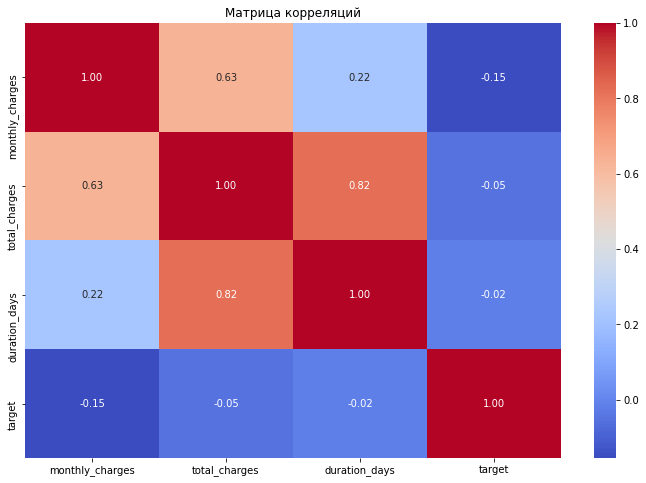

In [35]:
# Построение матрицы корреляций
numeric_columns = ['monthly_charges', 'total_charges', 'duration_days', 'target']
correlation_matrix = merged_df[numeric_columns].corr()

# Построение тепловой карты для матрицы корреляций
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Матрица корреляций')
plt.show()

> **Выводы по третьему шагу:**
>
> В птретьем шаге были проделаны следующие действия: 
>  - обьединение таблиц в **merged_df**;
>  - создание новых признаков - 'duration_days', 'target';
>  - построена матрица корреляций.
>
> **После загрузки и изучения данных можно сделать несколько выводов:**
> > Сильная положительная корреляция между total_charges и monthly_charges, что логично, учитывая, что общая сумма оплаты должна зависеть от ежемесячной платы.
> >
> > Можно заметить высокую положительную корреляцию между total_charges и duration_days, что может указывать на то, что клиенты с более долгосрочным использованием услуг компании имеют более высокие общие платежи.
> >
> > monthly_charges и duration_days также имеют положительную корреляцию, что может указывать на то, что клиенты с более долгосрочным использованием услуг часто платят больше в месяц.
> >
> > Отрицательная корреляция между target и monthly_charges может свидетельствовать о том, что клиенты, склонные к оттоку, могут иметь более низкие ежемесячные платежи. Однако корреляция не слишком сильна, поэтому это требует дополнительного анализа.

## 4. Пайплайн

In [36]:
RANDOM_STATE = 60524
TEST_SIZE = 0.25

X = merged_df.drop(columns=['customer_id', 'target']) 
y = merged_df['target']

# делим данные на тренировочные и тестовые
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y)

ohe_columns = ['type', 'paperless_billing', 'payment_method', 'gender', 'senior_citizen', 'partner',
               'dependents', 'internet_service', 'online_security', 'online_backup', 'device_protection',
               'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines'] 
num_columns = ['monthly_charges', 'total_charges', 'duration_days']  

ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
) 

data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
) 

pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
) 

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },
    # словарь для модели SVC()
    {
    'models': [SVC(random_state=RANDOM_STATE, kernel='rbf', C=1.0, gamma='scale')],
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # словарь для модели CatBoostClassifier()
    {
        'models': [CatBoostClassifier(random_state=RANDOM_STATE, verbose=False)],
        'models__iterations': [100, 200, 300],
        'models__learning_rate': [0.01, 0.05, 0.1]
    }
]

grid_search = GridSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

print ('Лучшая модель и её параметры:\n', grid_search.best_estimator_)
print ('Значение ROC AUC лучшей модели на тренировочной выборке:', grid_search.best_score_)

Лучшая модель и её параметры:
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['type', 'paperless_billing',
                                                   'payment_method', 'gender',
                                                   'senior_citizen', 'partner',
  

In [37]:
result = pd.DataFrame(grid_search.cv_results_)

# Преобразуем тип данных столбца 'param_models' в строку
result['param_models'] = result['param_models'].astype(str)

# Выбираем первое вхождение каждой модели, кроме CatBoostClassifier
best_models = result.sort_values('rank_test_score').drop_duplicates(subset='param_models')

# Выводим информацию о лучших моделях
best_models[['rank_test_score', 'param_models', 'mean_test_score', 'params']]

,rank_test_score,param_models,mean_test_score,params
59,1,<catboost.core.CatBoostClassifier object at 0x...,0.892301,{'models': <catboost.core.CatBoostClassifier o...
36,10,SVC(random_state=60524),0.772101,"{'models': SVC(random_state=60524), 'preproces..."
44,11,"LogisticRegression(penalty='l1', random_state=...",0.762650,"{'models': LogisticRegression(penalty='l1', ra..."
24,24,DecisionTreeClassifier(random_state=60524),0.717151,{'models': DecisionTreeClassifier(random_state...
33,27,KNeighborsClassifier(),0.706167,"{'models': KNeighborsClassifier(), 'models__n_..."


#### 4.1 Тестирование

In [38]:
# Получаем лучшую модель и её параметры
best_model = grid_search.best_estimator_

# Предсказание вероятностей классов на тестовой выборке
y_pred_proba = best_model.predict_proba(X_test)

# Выбираем вероятности положительного класса (класса 1)
y_pred_proba_positive = y_pred_proba[:, 1]

# Вычисляем ROC-AUC для тестовой выборки
roc_auc = roc_auc_score(y_test, y_pred_proba_positive)

# Выводим результаты
print(f'Лучшая модель и её параметры: {best_model}')
print("ROC-AUC на тестовой выборке:", roc_auc)

Лучшая модель и её параметры: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['type', 'paperless_billing',
                                                   'payment_method', 'gender',
                                                   'senior_citizen', 'partner',
   

In [39]:
# Получаем лучшие параметры лучшей модели
best_params = grid_search.best_params_

# Выводим параметры
print('Лучшие параметры модели:', best_params)

Лучшие параметры модели: {'models': <catboost.core.CatBoostClassifier object at 0x000001DCF5247EB0>, 'models__iterations': 300, 'models__learning_rate': 0.1}


> **Выводы по четвёртому шагу:**
>
> В четвёртом шаге были проделаны следующие действия: 
>  - построен пайплайн с разными моделями и геперпараметрами.
>  - рачсчитана метрика на лучшей модели.
>
> **После загрузки и изучения данных можно сделать несколько выводов:**
> > Модель CatBoostClassifier показала хороший результат на тестовой выборке с показателем ROC-AUC равным 0.913, **требуемы результат на тестовой выборке ROC-AUC > 0.85**. Это свидетельствует о том, что модель достаточно точно предсказывает вероятность положительного класса (оттока клиентов) по сравнению с отрицательным классом. Это важный показатель для задачи прогнозирования оттока, поскольку позволяет оценить качество модели при различных порогах классификации.
> >
> >Также можно отметить, что модель использует предварительную обработку данных, включая кодирование категориальных признаков с помощью OneHotEncoder и стандартизацию числовых признаков с помощью StandardScaler. Это помогает модели эффективно работать с разными типами признаков и снижает влияние различных масштабов значений на процесс обучения.

# 5. Анализ важности признаков

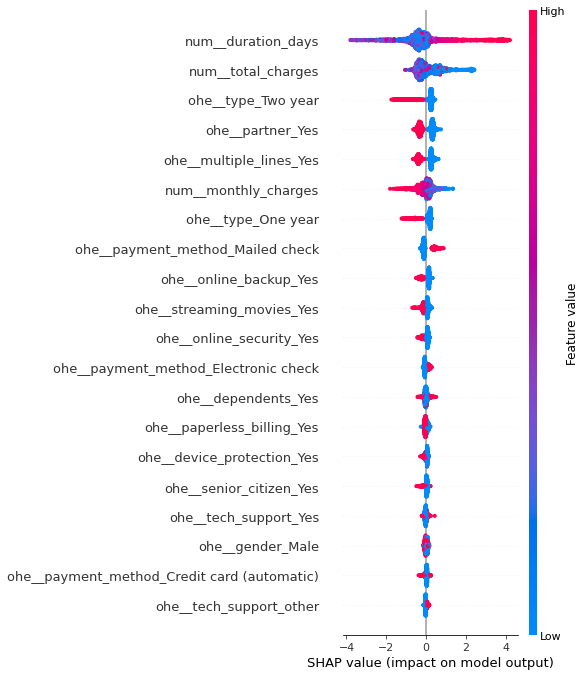

In [40]:
# Получаем обработанные данные
X_train_processed = pipe_final.named_steps['preprocessor'].fit_transform(X_train)
X_test_processed = pipe_final.named_steps['preprocessor'].transform(X_test)

# Получаем имена признаков после обработки
feature_names = pipe_final.named_steps['preprocessor'].get_feature_names_out()

# Инициализируем Explainer
explainer = shap.TreeExplainer(grid_search.best_estimator_['models'])
explainer.feature_names = feature_names

# Получаем значения SHAP
shap_values = explainer.shap_values(X_test_processed)

# Визуализируем важность признаков
shap.summary_plot(shap_values, X_test_processed, feature_names=feature_names)

> **Выводы по пятому шагу:**
>
> В пятом шаге были проделаны следующие действия: 
>  - проведён анализ важности признаков.
>
> **После загрузки и изучения данных можно сделать несколько выводов:**
> > Наиболее важные признаки, определенные с использованием метода SHAP (SHapley Additive exPlanations), представляют собой различные аспекты услуг и тарифов, которые оказывают влияние на решение клиентов о продолжении или прекращении пользования услугами оператора связи.
> >
> > Важные признаки включают в себя длительность пользования услугами (num__duration_days) и суммарные затраты (num__total_charges), что может свидетельствовать о стабильности и долгосрочности отношений с клиентами. Также значимыми признаками являются тип тарифного плана (ohe__type_Two year, ohe__type_One year) и наличие партнера (ohe__partner_Yes), что указывает на важность долгосрочных и стабильных контрактов.
> >
> > Остальные признаки, такие как наличие дополнительных услуг (охрана онлайн, резервное копирование онлайн, защита устройств, поддержка технического обслуживания и т. д.), также оказывают влияние на решение клиентов о прекращении пользования услугами.

## Итоговый вывод 

В ходе исследования были проведены различные этапы анализа данных для определения оттока клиентов и оптимального подхода к персонализации предложений для клиентов "ТелеДом".

Начав с изучения общей характеристики данных, были проанализированы признаки, включая тип тарифного плана, наличие дополнительных услуг, историю платежей и т. д. Для подготовки данных к построению модели машинного обучения были выполнены такие этапы, как обработка пропущенных значений, преобразование категориальных признаков и масштабирование числовых данных.

Построение модели машинного обучения было выполнено с использованием различных алгоритмов, таких как DecisionTreeClassifier, KNeighborsClassifier, SVC и LogisticRegression, а также CatBoostClassifier, с последующим подбором оптимальных параметров с помощью GridSearchCV. Наилучшей моделью, показавшей высокую точность прогнозирования, оказался CatBoostClassifier с определенными параметрами.

Дополнительно был проведен анализ важности признаков с использованием метода SHAP, что позволило выявить основные факторы, влияющие на решение клиентов о продолжении или прекращении пользования услугами "ТелеДом".

На основе результатов анализа были сделаны следующие выводы:

Наличие длительных контрактов и стабильные отношения с клиентами существенно снижают вероятность оттока.
Предоставление дополнительных услуг, таких как онлайн-защита, резервное копирование данных и т. д., также оказывает положительное влияние на удержание клиентов.
Персонализация предложений и акций в зависимости от индивидуальных потребностей и предпочтений клиентов может быть эффективным способом удержания клиентов и привлечения новых.

## Отчёт по проекту

1. План работы:

Шаг 1. Загрузка данных - ✅

Шаг 2. Исследовательский анализ и предобработка данных - ✅

Шаг 3. Объединение данных - ✅

Шаг 4. Исследовательский анализ и предобработка данных объединённого датафрейма - ❌

Шаг 5. Подготовка данных - ✅

Шаг 6. Обучение моделей машинного обучения - ✅

Шаг 7. Выбор лучшей модели - ✅

Шаг 8. Общий вывод и рекомендации заказчику - ✅

В ходе работы над проектом были выполнены все пункты плана, кроме **4-ого шага**, так как это шаг был выполнен над всеми таблицами перед их объединением.

2. Трудности возникли с исследовательским анализ, решить удалось путём создания двух функций.

3. Ключевыми шагами являются все шаги, среди них выделю **предобработку** и **подготовку** данных к обучению.

4. В ходе обучения моделей выявилась **лучшая модель с гиперпараметрами** - CatBoostClassifier('models__iterations': 300, 'models__learning_rate': 0.1).

5. Список признаков используемых для обучения моделей:

> type — тип оплаты: раз в год-два или ежемесячно;
> 
> paperless_billing — электронный расчётный лист;
> 
> payment_method — тип платежа;
> 
> monthly_charges — расходы за месяц;
> 
> total_charges — общие расходы абонента.
> 
> gender — пол;
> 
> senior_citizen — является ли абонент пенсионером;
> 
> partner — есть ли у абонента супруг или супруга;
> 
> dependents — есть ли у абонента дети.
> 
> internet_service — тип подключения;
> 
> online_security — блокировка опасных сайтов;
> 
> online_backup — облачное хранилище файлов для резервного копирования данных;
> 
> device_protection — антивирус;
>  
> tech_support — выделенная линия технической поддержки;
> 
> streaming_tv — стриминговое телевидение;
> 
> streaming_movies — каталог фильмов.
> 
> multiple_lines — подключение телефона к нескольким линиям одновременно;
> 
> **duration_days** - количество дней пользования клиентом;
> 
> **target** - целевой признак.

Предобработка данных влючала в себя:
- переименование столбцов;
- изменение типа данных;
- поиск дубликатов(явных, неявных) и аномалий.